# Preprocessing
**1.Read the data**

In [1]:
import pandas as pd
import numpy as np
df = pd.read_parquet("../data/curated/initialised_df.parquet")
df

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,airport_fee
0,2022-01-01 00:35:40,2022-01-01 00:53:29,3.80,142,236,1,14.50,3.0,3.65,0.0
1,2022-01-01 00:33:43,2022-01-01 00:42:07,2.10,236,42,1,8.00,0.5,4.00,0.0
2,2022-01-01 00:53:21,2022-01-01 01:02:19,0.97,166,166,1,7.50,0.5,1.76,0.0
3,2022-01-01 00:25:21,2022-01-01 00:35:23,1.09,114,68,2,8.00,0.5,0.00,0.0
4,2022-01-01 00:36:48,2022-01-01 01:14:20,4.30,68,163,1,23.50,0.5,3.00,0.0
...,...,...,...,...,...,...,...,...,...,...
9071239,2022-03-31 23:45:00,2022-04-01 00:01:00,3.57,48,262,0,18.33,0.0,1.00,NaN
9071240,2022-03-31 23:59:39,2022-04-01 00:06:09,2.04,48,238,0,9.75,0.0,2.00,NaN
9071241,2022-03-31 23:50:00,2022-04-01 00:08:00,0.59,48,4,0,17.33,0.0,2.23,NaN
9071242,2022-03-31 23:25:56,2022-03-31 23:32:37,1.26,158,68,0,8.80,0.0,2.57,NaN


**2.Handle Missing value**

In [2]:
# check missing data
df.isnull().sum()

tpep_pickup_datetime          0
tpep_dropoff_datetime         0
trip_distance                 0
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
tip_amount                    0
airport_fee              291055
dtype: int64

In [3]:
# Only airport fee has missing value, according to the data dictionary
# airport fee =1.25 for the trip picked up at LaGuardia or John F. Kennedy Airports.
# So if PULocationID = 132/138, it should be 1.25 and zero for else
df.loc[(df["PULocationID"]==132) | (df["PULocationID"]==138), "airport_fee"] = 1.25
df.loc[(df["PULocationID"]!=132) & (df["PULocationID"]!=138), "airport_fee"] = 0
df.isnull().sum()

# Note that in this situation, the airport fee which is not null and is wrong will
# also be corrected

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
tip_amount               0
airport_fee              0
dtype: int64

**3. check data validation**

In [4]:
# let's get the min and max to see if there are some unexpected error data
df.min()

tpep_pickup_datetime     2003-01-01 00:10:06
tpep_dropoff_datetime    2003-01-01 12:38:59
trip_distance                            0.0
PULocationID                               1
DOLocationID                               1
payment_type                               0
fare_amount                           -895.0
extra                                   -4.5
tip_amount                            -188.0
airport_fee                              0.0
dtype: object

In [5]:
df.max()

tpep_pickup_datetime     2022-05-24 17:41:50
tpep_dropoff_datetime    2022-05-24 17:43:27
trip_distance                      348798.53
PULocationID                             265
DOLocationID                             265
payment_type                               5
fare_amount                        401092.32
extra                                   33.5
tip_amount                            888.88
airport_fee                             1.25
dtype: object

In [6]:
# it is clear that the earliest time is for year 2003 and latest time for
# year 2022-05, which are not wanted
df = df[(df["tpep_pickup_datetime"] >= "2022-01-01 00:00:00")
    & (df["tpep_pickup_datetime"] < "2022-04-01 00:00:00")]
# if there is any trip that has earlyer dropoff than
# pickup shouldn't happen
df = df[df["tpep_pickup_datetime"] < df["tpep_dropoff_datetime"]]
df.shape

(9062722, 10)

In [7]:
# it is also clear that we have some trip distance = 0 which also
# shouldn't happen
df = df[df["trip_distance"] > 0]
df.shape

(8962765, 10)

In [8]:
# the minimum fare amout should be 2.5, cause it inital charge and the negative
# values on the fee, which shouldn't happen
df = df[(df["fare_amount"] >= 2.5) & (df["extra"] >= 0) 
    & (df["tip_amount"] >= 0) & (df["airport_fee"] >= 0)]
df.shape

(8918737, 10)

In [9]:
# the payment type range should be 1-6, 0 is unwanted
df = df[df["payment_type"] > 0]
df.shape

(8638583, 10)

In [10]:
# check what about now
df.min()

tpep_pickup_datetime     2022-01-01 00:00:08
tpep_dropoff_datetime    2022-01-01 00:04:57
trip_distance                           0.01
PULocationID                               1
DOLocationID                               1
payment_type                               1
fare_amount                              2.5
extra                                    0.0
tip_amount                               0.0
airport_fee                              0.0
dtype: object

The data seems to be fine now.

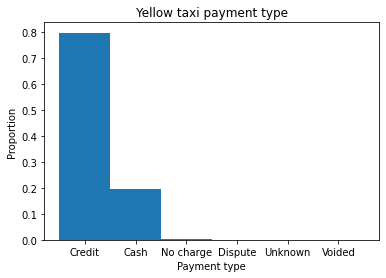

In [11]:
# the tip is only recorded for credit card. I decide to check
# the distribution of payment type and see whether it could be
# used to predict tips for the other data
from turtle import left
import matplotlib.pyplot as plt
plt.hist(df.payment_type, bins=6,range=(1,7), align='left', density=True)
plt.xlabel('Payment type')
plt.ylabel('Proportion')
plt.title('Yellow taxi payment type')
plt.xticks(range(1,7),("Credit","Cash","No charge","Dispute","Unknown","Voided"))
plt.show()

In [12]:
# it is clear that about 80% trip use credit card to pay, about 20% use cash
# the other payments are so little that could be ignored, therefore I decide
# to cut those methods
df = df[df["payment_type"] <= 2]
df.shape

(8605377, 10)

**4.Outlier removing**

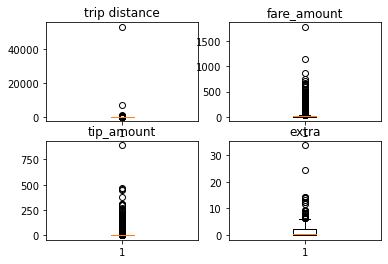

In [13]:
# plot the numeric variables to see their distribution
# I didn't app the airpot fee cause the min of it is 0, max is 1.25
plt.subplot(2,2,1)
plt.boxplot(df['trip_distance'])
plt.title("trip distance")
plt.subplot(2,2,2)
plt.boxplot(df['fare_amount'])
plt.title("fare_amount")
plt.subplot(2,2,3)
plt.boxplot(df['tip_amount'])
plt.title("tip_amount")
plt.subplot(2,2,4)
plt.boxplot(df['extra'])
plt.title("extra")
plt.show()

In [14]:
# it is clear that all these variables are heavly left skewed
# use 1.5 IQR to remove the outlier
for feature in ["trip_distance","fare_amount","tip_amount","extra"]:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[feature] >= (Q1 - 1.5 * IQR))&(df[feature] <= (Q3 + 1.5 * IQR))]
df.shape

(7309931, 10)

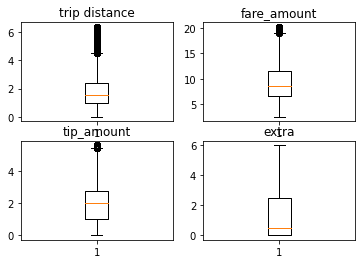

In [15]:
# let's see the box plot for now
plt.subplot(2,2,1)
plt.boxplot(df['trip_distance'])
plt.title("trip distance")
plt.subplot(2,2,2)
plt.boxplot(df['fare_amount'])
plt.title("fare_amount")
plt.subplot(2,2,3)
plt.boxplot(df['tip_amount'])
plt.title("tip_amount")
plt.subplot(2,2,4)
plt.boxplot(df['extra'])
plt.title("extra")
plt.show()

In [16]:
# it's seems fair enough, let's save the dataframe and move to the
# next stage
df.to_parquet("../data/curated/preprocessed_df.parquet")